# Introduction to gradients and automatic differentiation

### [Automatic_differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 2. Computing gradients

## 3. Gradient tapes

In [2]:
# Here is a simple example:

x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x**2

In [3]:
# Once you've recorded some operations, use GradientTape.gradient(target, sources) 
# to calculate the gradient of some target (often a loss) relative to some source (often the model's variables):

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

In [4]:
# The above example uses scalars, but tf.GradientTape works as easily on any tensor:

w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

In [5]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [6]:
# The gradient with respect to each source has the shape of the source:

print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


In [7]:
# Here is the gradient calculation again, this time passing a dictionary of variables:

my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.80596006, -6.2672353 ], dtype=float32)>

## 4. Gradients with respect to a model

In [8]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

In [9]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


## 5. Controlling what the tape watches

In [10]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [11]:
# You can list the variables being watched by the tape using the GradientTape.watched_variables method:
[var.name for var in tape.watched_variables()]

['x0:0']

In [12]:
# tf.GradientTape provides hooks that give the user control over what is or is not watched.

# To record gradients with respect to a tf.Tensor, you need to call GradientTape.watch(x):
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


In [13]:
# Conversely, to disable the default behavior of watching all tf.Variables, 
# set watch_accessed_variables=False when creating the gradient tape. 
# This calculation uses two variables, but only connects the gradient for one of the variables:

x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

In [14]:
# Since GradientTape.watch was not called on x0, no gradient is computed with respect to it:

# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## 6. Intermediate results

In [15]:
# You can also request gradients of the output with respect to intermediate values computed inside the tf.GradientTape context.

x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dx = 2 * y, where y = x ** 2
print(tape.gradient(z, y).numpy())

18.0


In [16]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # 108.0 (4 * x**3 at x = 3)
print(tape.gradient(y, x).numpy())  # 6.0 (2 * x)

[  4. 108.]
[2. 6.]


In [17]:
del tape   # Drop the reference to the tape

## 7. Notes on performance

## 8. Gradients of non-scalar targets

In [19]:
# A gradient is fundamentally an operation on a scalar.

x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


In [20]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


In [21]:
# Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


In [22]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

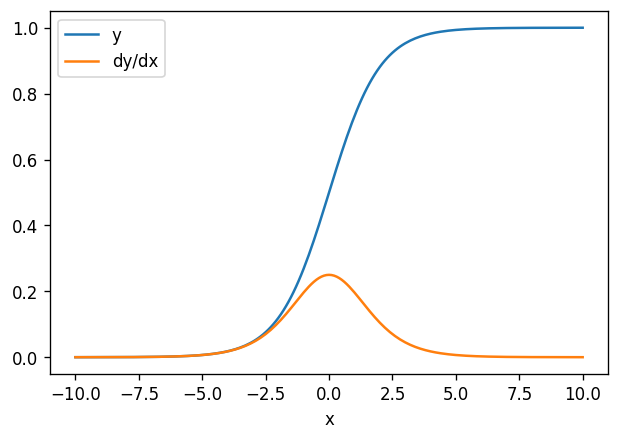

In [26]:
plt.figure(figsize=(6,4), dpi=120)
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## 9. Control flow

In [27]:
# Here a different variable is used on each branch of an if. 
# The gradient only connects to the variable that was used:

x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


In [28]:
dx = tape.gradient(result, x)

print(dx)

None


## 10. Getting a gradient of None

In [29]:
# When a target is not connected to a source you will get a gradient of None.
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


### i. Replaced a variable with a tensor

In [30]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


### ii. Did calculations outside of TensorFlow

In [31]:
# The tape can't record the gradient path if the calculation exits TensorFlow. 
# For example:

x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


### iii. Took gradients through an integer or string

In [32]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


### iv. Took gradients through a stateful object

In [33]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


## 11. No gradient registered

In [34]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')

LookupError: gradient registry has no entry for: AdjustContrastv2


## 12. Zeros instead of None

In [35]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)


# reference
### https://tensorflow.google.cn/guide/autodiff